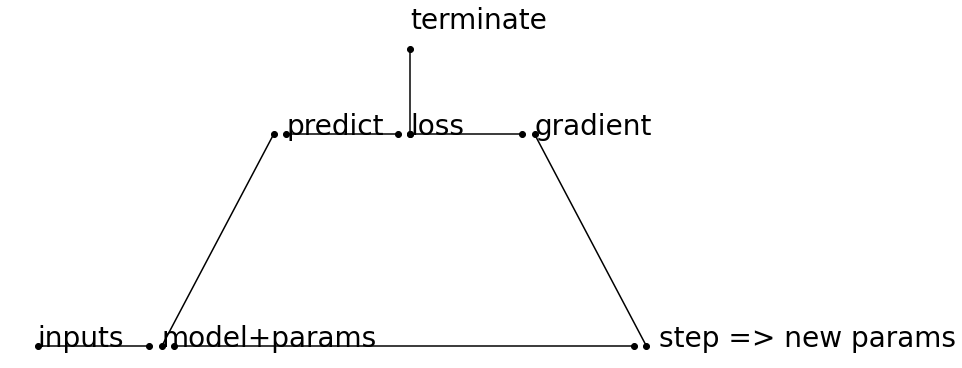

In [7]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns # seaborn does not really work with fastai...

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
make_chart()

### Estimating singnal value given short history currently available:

Let us make an function that when given, say values y=[y[t=-1], y[t=-1], y[t=0]] returns f(y) = y[1]. It can estimate the future function value given the few values at hand. 

Start by making some data:

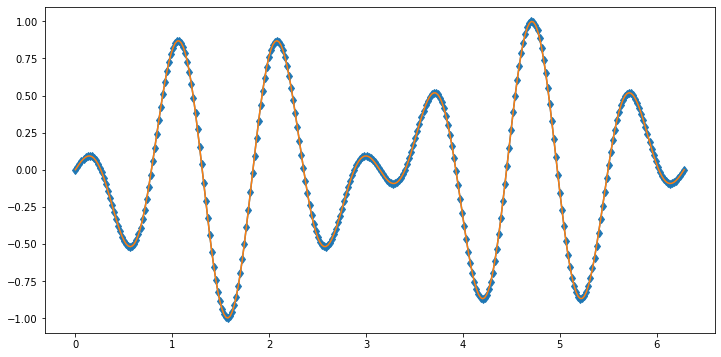

In [8]:
N = 300
error = .0

x = torch.linspace(0, np.pi*2, N) 
y = torch.sin(x)*torch.cos(6*x) #torch.sin(x)*x 
y_biased = y + torch.randn(N)*error

# This ised for validation:
y_val = torch.sin(x)*torch.cos(x) + torch.randn(N)*error

plt.plot(x.detach(), y_biased, '-d')
plt.plot(x.detach(), y, '-')

In [9]:
lentrain = 3
dn = 1
dx = (x[1] - x[0])*dn
#params = init_params(lentrain)

# Device a 'train set' - do not gen confused by the fact that the y values are used in the training..:
x_train = x.reshape(-1, lentrain)
y_train = y_biased.reshape(-1, lentrain)
# This is used to train:
X_train = torch.cat((x_train, y_train), 1)[:-1]
y_train = y_train[1:, dn-1].reshape(-1, 1)

#Validation set:
y_valid = y_val.reshape(-1, lentrain)
X_valid = torch.cat((x_train, y_valid), 1)[:-1]
y_valid = y_valid[1:, dn-1].reshape(-1, 1)

# These are the actual points that are predicted:
x_train = x_train[1:, dn-1].reshape(-1, 1)

display(animate(x_train, y_train))
X_train[:5], x_train[:5], y_train[:5]

(tensor([[ 0.0000,  0.0210,  0.0420,  0.0000,  0.0208,  0.0407],
         [ 0.0630,  0.0841,  0.1051,  0.0585,  0.0735,  0.0847],
         [ 0.1261,  0.1471,  0.1681,  0.0915,  0.0931,  0.0892],
         [ 0.1891,  0.2101,  0.2312,  0.0794,  0.0636,  0.0419],
         [ 0.2522,  0.2732,  0.2942,  0.0144, -0.0184, -0.0560]]),
 tensor([[0.0630],
         [0.1261],
         [0.1891],
         [0.2522],
         [0.3152]]),
 tensor([[ 0.0585],
         [ 0.0915],
         [ 0.0794],
         [ 0.0144],
         [-0.0977]]))

In [10]:
def simple_model_predict(params, X_train):
    """
    Device a simple model that tries to predict the value of y at x + dx.
    The y[-1] is assumed to be at y[x] and x = 0,1,2,....
    """
    
    x = X_train[:, :lentrain]
    y = X_train[:, lentrain:]
    
    def get_derivs_():
        """
        Return the derivatives of y w.r.t. x
        """
        dydx = (y[:, -2] - y[:, -1])/(x[:, -2] - x[:, -1]) #np.gradient(y, x)
        dydx2 =(y[:, -3] - y[:, -2])/(x[:, -3] - x[:, -2]) #np.gradient(y, x)

        d2ydx2 = 2*(dydx - dydx2)/(x[:, -3] - x[:, -1]) #np.gradient(dydx, x)
        return y[:, -1], dydx, d2ydx2
    
        
    y0, dydx, d2ydx2 = get_derivs_()
    y_pred = params[0]*y0 + params[1]*dydx*dx + params[2]*d2ydx2*dx**2 
        
    return y_pred.reshape(-1, 1)

    

def rms_loss(y_true, y_pred):
    """
    Root mean squared loss function for the regression task
    """
    
    if y_true.shape != y_pred.shape:
        print(y_true.shape)
        print(y_pred.shape)
        raise TypeError('The sizes of arrays do not match')
    
    return ((y_true - y_pred)**2).mean()

def update_params(lr, params): 
    """
    Parameter updater. We use gradient descent for the update process.
    The gradients are provided by pytorch. 
    """
    if isinstance(params, tuple):
        for p in params:
            p.data -= lr * p.grad.data
            p.grad = None #.zero_()
        return params
    else:
        params.data -= lr * params.grad.data
        params.grad = None
        return params
    
def init_params(size, std=1.0): 
    # Note that since these are our parameters that we want to manipulate we 
    # ask pytorch to keep track of their gradients.
    # The teminology can be a little misleading for some. 
    # Eventually we will have:
    # G_i = [grad(loss)]_i = d loss / d param[i]
    # and the G_i is found from params.grad.data[i]
        
    return (torch.randn(size)*std).requires_grad_()

def plot_estimate(preds, params=None, niter=None, valid=False):
    """
    Plot estiamate given by model and compare with actual data:
    """
    
    if not valid:
        
        plt.plot(x.detach(), y_biased, color='black', label='True')
        plt.plot(x.detach(), y_biased, '-', lw=.5) #, color='black')
        title = 'Loss: {:.5f}\n'.format(rms_loss(y_train, preds))
    else:
        plt.plot(x.detach(), y_val, '-', lw=.5, color='black', label='True')
        title = 'Loss: {:.5f}\n'.format(rms_loss(y_valid, preds))
    
    
    plt.scatter(x_train.detach(), preds.detach(), label='Estim')
    plt.legend()
    
    
    if params is not None:
        title += 'params: {}\n'.format(params.data)
    if niter is not None:
        title += 'niter: {}'.format(niter)
    
    plt.title(title)
    
    plt.show()

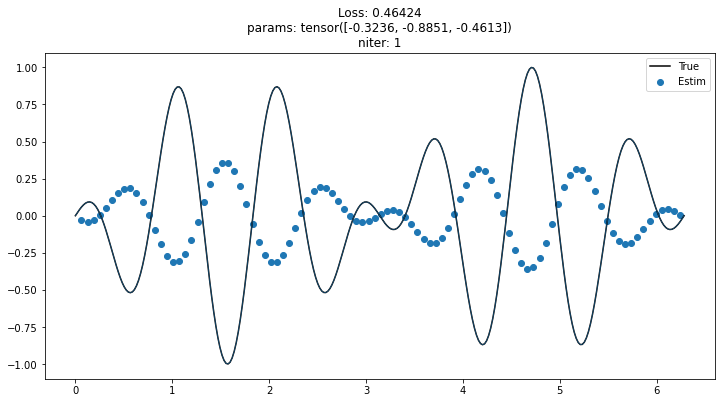

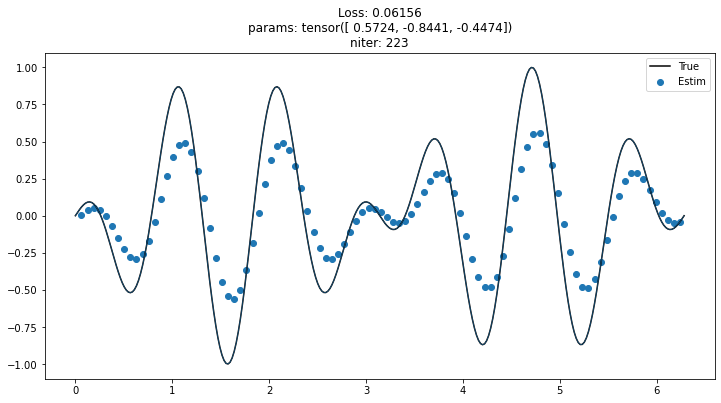

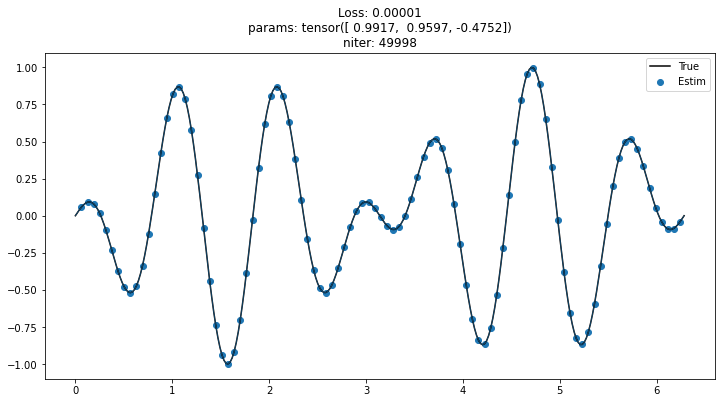

Validation


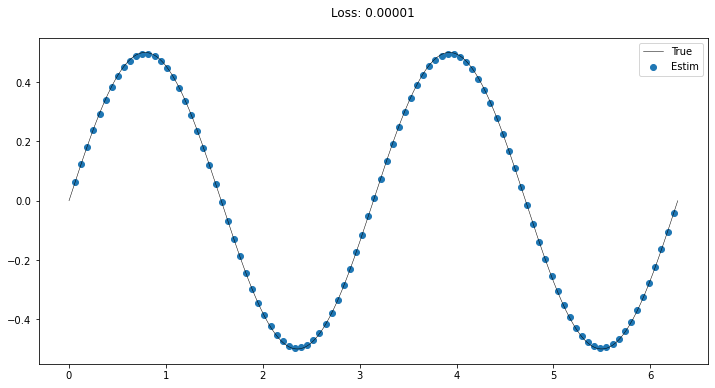

In [11]:
params = init_params(3)
do_anim = False
do_plot = not do_anim

N_iter = 50000
nplots = 3
plot_at_iter = np.logspace(0, np.log2(N_iter-1), nplots, base=2).astype(int)

for j in range(N_iter):
    # With the current parameters predict in the training set:
    preds = simple_model_predict(params, X_train)
    # Check how you did by evaluating the loss:
    loss = rms_loss(y_train, preds)
    # Take the gradient of the loss - you get the direction to which the parameters ought to be shifted to get lesser loss.
    loss.backward()
    # Update the params in the direction by little amount:
    params = update_params(1e-2, params)
    
    if j in plot_at_iter:
        if do_plot: plot_estimate(preds, params, j)
        if do_anim: display(animate(x_train, y_train, preds.detach()))
        
print('Validation')
plot_estimate(simple_model_predict(params, X_valid), valid=True)

### Simple nnet model:

In [12]:
w1 = init_params((3, 10))
b1 = init_params(10)
w2 = init_params((10, 10))
b2 = init_params(10)
w3 = init_params((10, 1))
b3 = init_params(1)

params = (w1, b1, w2, b2, w3, b3)

def nnet_predict(params, X_train):
    
    w1, b1, w2, b2, w3, b3 = params
    y = X_train[:, lentrain:]
    
    res = y@w1 + b1
    res = res.max(torch.tensor(0.0))
    res = res@w2 + b2
    res = res.max(torch.tensor(0.0))
    res = res@w3 + b3
    
    return res

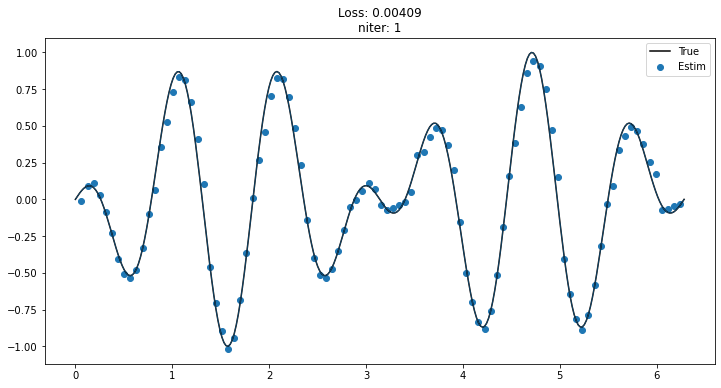

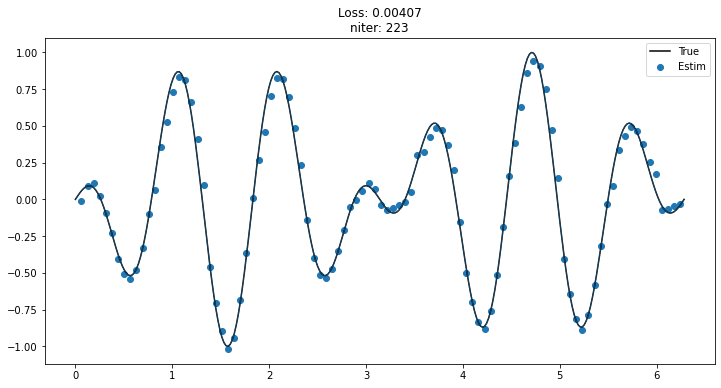

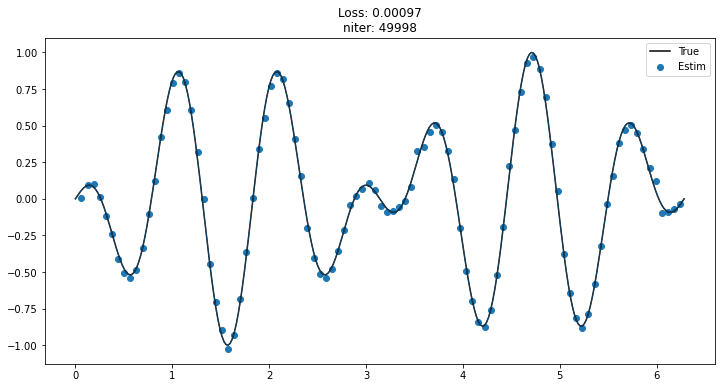

Validation


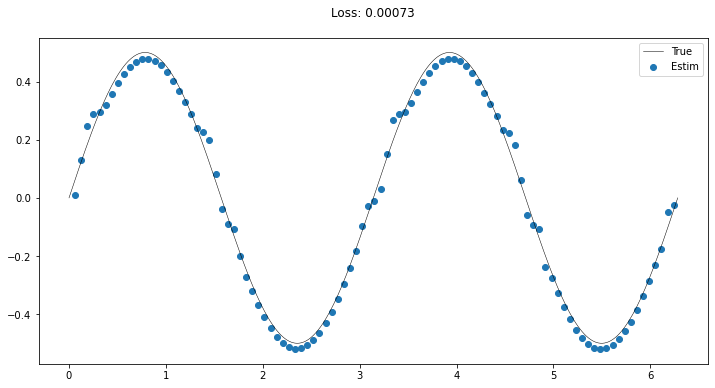

In [18]:
do_anim = False
do_plot = not do_anim

for j in range(N_iter):
    
    preds = nnet_predict(params, X_train)
    loss = rms_loss(y_train, preds)
    loss.backward()
    update_params(1e-3, params)
    
    
    if j in plot_at_iter:
        if do_plot: plot_estimate(preds, niter=j)
        if do_anim: display(animate(x_train, y_train, preds.detach()))
        
print('Validation')
plot_estimate(nnet_predict(params, X_valid), valid=True)

### Using fastai

We shall now apply the exact same steps as taken above to separate handwritten digits 3 and 7. The inputs will be the pixel values, we employ touch larger network, loss function is updated for classification, but otherwise we take the same steps and apply the same principles.

First we need to load data:

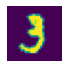

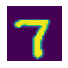

In [19]:
from fastai.vision.all import *
import torch.nn as nn
import matplotlib as mpl

path = untar_data(URLs.MNIST_SAMPLE)

# Load:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

# Put in lists:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

# Stack into tensors:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# Make a train set
X_train = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
y_train = tensor([1]*len(threes) + [0]*len(sevens)) #.unsqueeze(1)

# Finally combine the X and y into (X, y) tuples:
dset = list(zip(X_train, y_train))

#Make fastai dataloader:
dl = DataLoader(dset, batch_size=256)

# The whole above business for valid set:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255
X_valid = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28) 
y_valid = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)) #.unsqueeze(1)
valid_dset = list(zip(X_valid, y_valid))
valid_dl = DataLoader(valid_dset, batch_size=256)

# Dataloaders are provded by fastai and they ease the delivery of data to learners:
dls = DataLoaders(dl, valid_dl)

show_image(three_tensors[0]);
show_image(seven_tensors[0]);

#### Here we build a simple model using fastai and pytorch to learn and then predict in the above dsets:

In [ ]:
lr = 1e-3

# Pytorch provides a linear model (this makes a simple neural net similar to before nnet_predict): 
simple_net = nn.Sequential(
    # First linear layer takes the input - the shape needs to match with the pixels from images (we flattened the images to 1D)
    nn.Linear(28*28, 30),
    # Use relu to bring non-linearity.
    nn.ReLU(),
    # The last layer takes the inputs from ReLU and spits out 2 numbers. One for 3 and one for 7
    nn.Linear(30, 2),
    # We do not do anything else here since the softmax is taken at the cross entropy.
)

# Learners can take care of the whole learning process. Convenient:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=accuracy)

# The you call the fit:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.160135,1.764621,0.504416,00:00
1,0.127325,0.490191,0.788027,00:00


### Lets the do the full MNIST:

The whole business of loading data can be executed with .from_folder function

In [ ]:
path = untar_data(URLs.MNIST)
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing') #, vocab=range(10))
dls.show_batch()
learn = cnn_learner(dls, resnet18, pretrained=False, metrics=accuracy, loss=F.cross_entropy) #loss=my_cross_e) #loss=F.nll_loss)
learn.lr_find()

In [ ]:
#learn.fit_one_cycle(5, 0.005)
learn.fine_tune(10, .005) 

In [ ]:
learn.recorder.plot_loss()

In [ ]:
x,y = dls.one_batch()
preds,_ = learn.get_preds(dl=[(x,y)])
show_image(x[0]), F.softmax(preds[0], dim=0).argmax(), y[0]

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
for idx in interp.top_losses()[1][:5]:
    print('pred: {} True: {}'.format(F.softmax(interp.preds[idx], dim=0).argmax(), interp.targs[idx]))
    show_image(interp.inputs[idx])

In [ ]:
interp.plot_confusion_matrix() 

### Softmax

$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$

### About loss functions:

#### Likelihood: 
Consider instance training instance $\mathbf{x}_i$. $q_{i, c_i}$ is the probability given by the model for class $c_i$. Then the likelihood $\mathcal{L}$ of given outcome becomes:

$\mathcal{L} = \prod_{i} q_{i,c_i}$

The product can easily overflow or underflow or flow wherever (try typing such an thing into your Texas Ti-82!). We thus take logarhithm of the $\mathcal{L}$, and divide by $-N$, where N is the number of training instances, after all we are trying to maximize the likelihood and this can be done by minimizing the negative of its logarhithm. We call this quantity negative log-likelihood and use it, 

$l = -\frac{1}{N}\log \mathcal{L} = -\frac{1}{N} \log \left(\prod_{i} q_{i,c_i} \right) = -\frac{1}{N}\sum_{i} \log q_{i, c_i}$.

For the sake of seeing something familiar, say now that for given true label the model would always output the same $q_{c}$. Then we can reformulate the above sum ($n_c$ amount of class $c$ instances in training data),

$l = -\sum_c \frac{n_c}{N} \log q_c = - \sum_c p_c \log q_c$,

The lass term is called cross-entropy and it is one of the possible loss functions to pick for classification tasks. However, the formulation above holds *only* when the model is consisten in its outputs - better stick with the first formulation. 

Below we play a touch with the loss functions to make sure all is well:

In [174]:
def my_nll(preds, classes):
    """
    output the negative log_likelihood similar to F.nll_loss - NOTE!!! F.nll_loss
    expects that you provide ith with the logs of the class probabilities! This is weird (considering the function name),
    but it apparently has some computational reasons.
    """
    return -preds[range(len(preds)), classes].sum()/len(preds)

def my_cross_e(preds, classes):
    
    preds_log = torch.log_softmax(preds, dim=1)
    return my_nll(preds_log, classes)

N = 10
# These are outputs of a binary calssifier:
preds = torch.rand((N, 2))*6 - 3
# These are the true classes:
classes = torch.randint(0, 2, (len(preds), ))

# To check the output of softamx:
preds_prob = F.softmax(preds, dim=1) 

print(preds, preds_prob)

# To get the logs (and also softmaxing over the first dimension) we use
preds_log = F.log_softmax(preds, dim=1)

# Then when calling
my_nll(preds_log, classes), F.nll_loss(preds_log, classes), my_cross_e(preds, classes), F.cross_entropy(preds, classes)

tensor([[ 0.7672,  2.4931],
        [-1.4453,  2.8220],
        [-2.8205, -0.5760],
        [-1.8398, -2.7130],
        [-1.4855,  0.2546],
        [ 2.4240, -2.5364],
        [-2.5092, -0.3532],
        [ 2.5431,  1.8495],
        [-2.9564, -1.3039],
        [ 2.5044,  1.0264]]) tensor([[0.1511, 0.8489],
        [0.0138, 0.9862],
        [0.0958, 0.9042],
        [0.7054, 0.2946],
        [0.1493, 0.8507],
        [0.9930, 0.0070],
        [0.1038, 0.8962],
        [0.6668, 0.3332],
        [0.1608, 0.8392],
        [0.8143, 0.1857]])


(tensor(1.3148), tensor(1.3148), tensor(1.3148), tensor(1.3148))

### make chart

In [2]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

rc('animation', html='jshtml') #, html='html5')
#mpl.rcParams['figure.figsize'] = (12,6)
def make_chart():
    _, ax = plt.subplots()
    
    steps = \
    [[0, 0, 'inputs'],
     [1, 0, 'model+params'],
     [2, 1, 'predict'],
     [3, 1, 'loss'],
     [4, 1, 'gradient'],
     [5, 0, 'step => new params']
     ]
        
        
    def get_line(key):
        for s in steps:
            if s[2] == key: 
                return s
    fsize=28
    dx = .1
    for i, s in enumerate(steps):
        ax.text(*s, fontsize=fsize)
        if i>0: ax.plot([steps[i-1][0], steps[i][0] - dx], [steps[i-1][1], steps[i][1]], '-o', color='black')
    
    add_lines = [['step => new params', 'model+params'], ['loss', [0, .5, 'terminate']]]
    for aline in add_lines:
        s = get_line(aline[0]) 
        if isinstance(aline[1], str):
            s2 = get_line(aline[1]) 
            plt.plot([s[0]-2*dx, s2[0]+dx], [s[1], s2[1]], '-o', color='black') 
        else:
            x, y, text_ = aline[1]
            ax.text(x + s[0], y+s[1], text_, fontsize=fsize)
            plt.plot([s[0], s[0]+x], [s[1], s[1]+y-dx], '-o', color='black') 
    
    
    plt.axis('off')


def animate(x, y, pred=None):
    
    fig, ax = plt.subplots()
    
    x = x.flatten()
    y = y.flatten()
    if pred is not None: pred = pred.flatten()
        
    ln_true, = plt.plot([], [], '-', color='black', lw=1, label='True')
    ln_pred, = plt.plot([], [], '-o', color='blue', lw=1, label='Estim')
    
    nFrames = len(x) - 2
    xlim = np.array([-5, 1])
    ylim = np.array([y.min(), y.max()])*1.1
    
    
    def init():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.vlines(0, *ylim)
        ax.axvspan(-dx/dn*lentrain, 0, color='blue', alpha=0.2)
        ax.legend()
        #ax.set_aspect('equal')
        return ln_true, ln_pred, 

    def update(frame):
        
        x_ = x[:frame+2] - x[frame]
        y_ = y[:frame+2]
        
        ln_true.set_data(x_[:-1], y_[:-1])
        
        if pred is not None:
            
            ln_pred.set_data(x_, pred[:frame+2]) #, [0, Lcm_*.1])
        
            #sc.set_offsets(np.hstack((xdata[1:], ydata[1:])))
        
        return ln_true, ln_pred, 

    ani = FuncAnimation(fig, update, 
                        frames=np.arange(nFrames-1), 
                        interval=1/24*1000,
                        init_func=init, blit=True)
    
    plt.close() # Remove the otherwise annoying extra plot..
    return HTML(ani.to_jshtml())